# Random Numbers and Monte Carlo Methods in Particle Physics

1st part -- Random Numbers: interactive notebook presentation

2nd part -- Monte Carlo Methods [slides](Z_MC_all.pdf)

---

# Random Numbers (on a computer)
With material from previous lecture/course prepared by Alexander Mann (*etal*) .

## Example 1: Buffon's needle
* “Buffon's needle problem” (Graf G.L.L. von Buffon, 1707 – 1788)
* draw parallel, equidistant lines (distance $d$), throw $N$ needles (length $l\leq d$)
* probability for needle intersecting with line: $p = l_\text{eff}/d = l|\cos \phi|/d$
* integrate, assuming flat distribution for angle $\phi$: 
$$p = \int_0^{2\pi} \frac {l \left|\cos {\varphi}\right|}{d} \frac {\mathrm d \varphi}{2\pi}
    = \frac {l}{2\pi d} 2 \int_{-\pi/2}^{\pi/2} \cos\varphi \, \mathrm d \varphi
    = \frac {2l}{\pi d}$$
* von Mises: $N_\text{Treffer}/N \to p$ for $N\to\infty$ 
$$\tfrac{2\cdot N \cdot l}{N_\text{Treffer} \cdot d} \rightarrow \pi$$

What do you get for $\pi$ here?
[![](./figures/Buffon_Streicholz_1.jpg)](https://en.wikipedia.org/wiki/File:Streicholz-Pi.jpg)

In [1]:
ntot = 17
ncross = 11
print(2*ntot/ncross)

3.090909090909091


## Example 2: area of a circle
* also here, we determine $\pi$, but this via random hit counting to get the area of a circle
* approximate $\pi$ as ratio of hits $t$ and tries $n$:
  * $\lim_{n\to\infty} t/n = \pi / 4$ 
  * Why does this hold?

How to define a circle:
* circle = shape consisting of all points in a plane at a given distance from the center
* unit circle, using Euclidean distance in 2-D: $x^2 + y^2 \leq 1$

Implementation:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
xy    = np.random.rand(2, 10000)
xy2   = np.sum(xy ** 2, axis=0)
valid = xy2 < 1
good  = xy[:, valid]
bad   = xy[:, ~valid]

In [4]:
xy2.shape

(10000,)

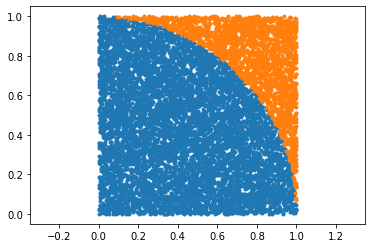

In [5]:
plt.plot(*good, ".")
plt.plot(*bad, ".");
plt.axis("equal");

In [ ]:
valid

In [6]:
pimc=np.mean(valid) * 4
pimc

3.1484

Can easily be generalized to higher dimensions:
* e.g. for a sphere: $x^2+y^2+z^2 \leq 1$
* N dimensions: $\sum_{i=1}^N x_i^2 \leq 1$

Volume of a sphere:

In [ ]:
xyz   = np.random.rand(3, 10000)
valid = np.sum(xyz ** 2, axis=0) < 1
good  = xyz[:, valid]
bad   = xyz[:, ~valid]
print("MC:      ", np.mean(valid)*8) # explain: why MC?
print("Analytic:", 4 / 3 * np.pi)

## Generating random numbers
We have seen that random numbers are useful / necessary to do (Monte Carlo) integrations on a computer. What is behind the `np.rand` function, i.e. how can we construct random numbers using a deterministic system like a computer?

* first task: we need a generator for random numbers
  * will then see that we can generate random numbers following arbitrary distributions (Gaussian, Poissonian, exponential, ...) from this
* on a deterministic computer, we can only generate *pseudo-random numbers*
  * special hardware for true random numbers (important for secure cryptography: attacker must not be able to infer random numbers) 
* we want these *pseudo-random numbers* to be
  * independently and identically distributed (i.i.d.) 
  * have a long period
  * fast to compute, easy on memory
  * reproducible (for debugging)
* pseudo-random numbers with these properties are suitable for our purposes (e.g. MC integration)

### Simple random-number generator: [linear congruential generator](https://en.wikipedia.org/wiki/Linear_congruential_generator)
* recursive definition: $I_j=(a\cdot I_{j-1}+c) \mod m$ 
* 3 integer constants: multiplier $a$, increment $c$, modulus $m$ 
* plus: start (or seed) value $I_0$ (*random seed*)
* generates sequence $I_1,I_2,...$ with $0 \leq I_j \leq m-1$
  * $I_j$ is periodic sequence with (maximum) period $m$
  * $u_j = I_j/m \in [0, 1)$

In [7]:
def lin_cong_iter(c, a, m, I_0):
    """implements a linear congruential generator"""
    I_j = I_0

    while True:
        yield I_j # <- Python generator
        I_j = (a * I_j + c) % m
        if I_j == I_0:
            # arrived at seed value again
            yield I_j
            break

In [12]:
f = lin_cong_iter(0, 3, 7, 1)

In [11]:
next(f)

2

In [13]:
list(lin_cong_iter(0, 3, 7, 1))

[1, 3, 2, 6, 4, 5, 1]

Do these look random? Can you predict the next number from the previous numbers without knowing the implementation?

Map to range $[0,1)$:

In [ ]:
list(i / 7 for i in lin_cong_iter(0, 3, 7, 1))

### Testing randomness
* correlations will spoil MC computations, results will be biased (i.e. wrong)
* define suite of tests (e.g. [TestU01](https://en.wikipedia.org/wiki/TestU01)) that random-number generators have to pass, e.g.
  * test flatness of distributon ($\chi^2$ tests for sub-intervals of $[0,1)$)
  * correlation tests ([spectral tests](https://en.wikipedia.org/wiki/Spectral_test))
  
Let's do a spectral test of our LCG:

In [14]:
# generate some random numbers
lcg_numbers = list(lin_cong_iter(a=57, c=1, m=256, I_0=10))[:-1]
print(len(lcg_numbers))

256


In [15]:
# numpy's random numbers
real_rand = np.random.randint(low = 0, high = 256, size = len(lcg_numbers))

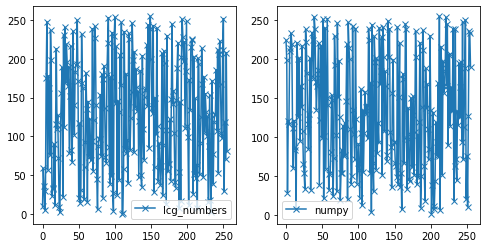

In [16]:
# plot sequence
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(range(len(lcg_numbers)), lcg_numbers, "x-", label = "lcg_numbers")
axs[0].legend()
axs[1].plot(range(len(lcg_numbers)), real_rand, "x-", label = "numpy")
axs[1].legend()
plt.show()

No visible difference.

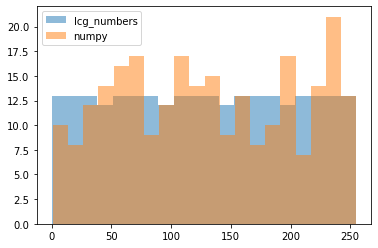

In [17]:
# flatness
#fig, axs = plt.subplots(1, 1, figsize=(8, 4))
plt.figure()
plt.hist(lcg_numbers, bins = 20, alpha = 0.5, label = "lcg_numbers")
plt.hist(real_rand, bins = 20, alpha = 0.5, label = "numpy")
plt.legend()
plt.show()

## 🤔

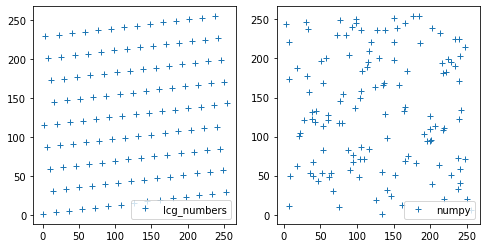

In [18]:
# spectral test in 2-D
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(lcg_numbers[::2], lcg_numbers[1::2], "+", label = "lcg_numbers")
axs[0].legend()
axs[1].plot(real_rand[::2], real_rand[1::2], "+", label = "numpy")
axs[1].legend()
plt.show()

## 😲

#### Excercise

Below are lcg settings corresponding to famous case of IBM **randu** Generator  which was popular generator in the 60s.

What's wrong with it?

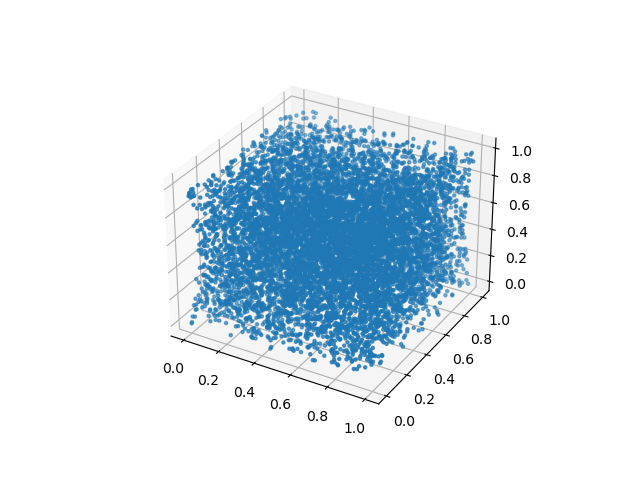

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget 
# currently only works on jupyterhub with python3.10 env
m = 2147483648
fr = lin_cong_iter(a=65539, c=0, m=m, I_0=10)
ntot=30000
lr=np.array([ next(fr)/m for i in range(ntot)])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(lr[0::3],lr[1::3],lr[2::3],marker='.')
plt.show()
           

## Random numbers with arbitrary distributions
Now that we have a generator for i.i.d. random numbers, let's get back to the point of transforming these into random numbers for arbitrary probability distributions. We will look at:
* inverse transform sampling (analytic, thus efficient)
* rejection sampling (useful if inversion of PDF not possible)
* special cases (e.g. Gaussian random numbers)

For the inverse transform sampling, we need to compute the cumulative distribution function (CDF) $F$ for the probability distribution function (PDF) $f$ that we want to sample from: 
$$F(x): x \to [0,1], F(x) \,\dot{=}\, \int_{-\infty}^x f(t) \mathrm dt,$$
and its inverse $F^{-1}$.

Some PDFs for normal distributions:
![](../figures/Normal_Distribution_PDF.png) 

Corresponding CDFs:
![](../figures/Normal-distribution-cumulative-density-function-many.png)

[Inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling): $F^{-1}: [0,1] \to \operatorname{domain}(f)$ gives random numbers $X$ distributed according to $f$ when using i.i.d. random numbers $U$ as input, $X = F^{-1}(U)$.

### Inverse Transform Example: exponentially distributed random numbers
* PDF: $f(x) = \lambda \cdot \exp(-\lambda \cdot x)$ for $x\geq0$
* CDF: $F(x) = \int_{t_\text{min} = 0}^{x}\lambda \cdot \exp(-\lambda\cdot t) \mathrm dt = [-\exp(-\lambda \cdot t)]_0^x =  1 - \exp(-\lambda \cdot x)$ 
* inverse: $x(u) = F^{-1}(x) = -\ln(1-u)/\lambda = -\ln(u)/\lambda$

In [ ]:
# generate
random_u = np.random.random(300000)
_lambda  = 2
random_x = -np.log(random_u)/_lambda

# plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(random_u, bins = 100)
axs[1].hist(random_x, bins = 100)
axs[1].set_yscale('log')
plt.show()

### Rejection Sampling Example: Gaussian distributed random numbers
For a Gaussian distribution $f(x) = \exp(-x^2/2) / \sqrt{2\pi}$, there is no analytic inverse of the CDF, so we cannot use inverse transform sampling. Instead, we will introduce [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling). The principle is the same as what we used to compute the area of a circle above. In its simplest form:
* define the range to draw samples from, $[x_\text{min}, x_\text{max}]$
* determine the maximum value of the PDF, $f_\text{max}$, over this range
* draw two i.i.d. random numbers $u_1$, $u_2$, map $u_1$ to $u_1' \in [x_\text{min}, x_\text{max}]$ and $u_2$ to $u_2' \in [0, f_\text{max}]$
* if $u_2' < f_\text{max}$, accept $u_1'$ as a sample from $f(x)$, otherwise repeat

In [ ]:
def f(x):
    # note: ufunc
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)

# ranges
xmin  = -3
xmax  = +3
fmax  = 0.5
# uniforms
xs    = xmin + np.random.random(10000) * (xmax-xmin)
ys    = np.random.random(10000) * fmax
# accept or reject
valid = ys < f(xs)

In [ ]:
# plot
plt.figure()

# plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(xs[ valid], ys[ valid], ".")
axs[0].plot(xs[~valid], ys[~valid], ".");
axs[1].hist(xs[valid], bins = 50)
plt.show();

This is quite inefficient, in particular if the fraction of our sampling box covered by the area under $f(x)$ is small:

In [ ]:
print("Acceptance rate:", sum(valid) / len(valid))

Ideas to improve this are *importance sampling* (sample subranges with large $f(x)$ with higher frequency) or to approximate the function with a known (strictly smaller) analytic function and draw samples from this (and the remainder if large).

For special cases, there may be more efficient alternatives. One example for the Gaussian distribution is the [Box-Muller method](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform), which can produce 2 random Gaussian-distributed numbers from 2 i.i.d. input random numbers:

In [ ]:
def BoxMuller(u1, u2):
    """Box–Muller transform (basic form)"""
    # two random numbers in, two out
    f1 = np.sqrt(-2*np.log(u1))
    f2 = 2*np.pi*u2
    gauss1 = f1 * np.cos(f2)
    gauss2 = f1 * np.sin(f2)
    return gauss1, gauss2

In [ ]:
u1 = np.random.random(10000)
u2 = np.random.random(10000)
g = BoxMuller(u1, u2)
vals = np.concatenate(g)
plt.figure()
plt.hist(vals, bins = 50);


In [ ]:
# fit gaussian
from scipy.stats import norm
gp=norm.fit(vals)
print('gaussian fit :', gp)
rvn=norm(*gp)
plt.figure()
p,x,*r=plt.hist(vals,bins=50,density=1) 
plt.plot(x,rvn.pdf(x));
plt.yscale('log')

### Random generators in `numpy.random` and `scipy.stats` 

`numpy.random` and `scipy.stats` provide random numbers for a large number of distributions.
Both are based on the Mersenne Twister (https://en.wikipedia.org/wiki/Mersenne_Twister), a widely used high-quality generator. The `numpy` versions simply generate random numbers while the `scipy` versions provide in addition useful functions related to the distribution.

In [ ]:
np.random

In [ ]:
import scipy.stats as stats

In [ ]:
stats?

In [ ]:
# generate poisson distributed rns
#b=stats.poisson.rvs(0.61,size=200) # scipy.stats version
b=np.random.poisson(0.61,200) # numpy.random version
plt.hist(b,bins=10,range=(0,10))

### Monte Carlo integration


An important application of random number is Monte Carlo integration.
 Suppose we want to find 
$$
I = \int_a^b f(x) dx
$$
in some region. 

In a simple scenario we can approximate that by simply using $n$ uniformly distributed random numbers $x_i$ (between $a$ and $b$) :


$$
I \approx \bar{f_n} = \frac{1}{n} \sum_{i=1}^n f(x_i)
$$



#### Demonstration for some weird function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from scipy.integrate import quad

In [ ]:
def f(x):
    return (x * np.cos(67*x) + np.sin(17*x))**2

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))


#### Exact solution with sympy

In [ ]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
integrate((x * cos(67*x) + sin(17*x))**2, (x, 0,1)).evalf(6)



#### MC integration

conceptually very simple, just randomly evaluate function in interval and take mean value:

In [ ]:
nrnd = 10000000
x = np.random.uniform(0, 1, nrnd)
sol = np.mean(f(x))
print(f'{nrnd:10.0f} {sol:.6f}')

In [ ]:
# check accuracy
for n in np.logspace(1,8,8):
    x = np.random.uniform(0, 1, int(n))
    sol = np.mean(f(x))
    print(f'{n:10.0f} {sol:.6f}')

#### Uncertainty estimate

The uncertainty of the MC integration can be estimated as


$$
\Delta  \approx \sqrt{Var(f(x)) / n} 
$$


**Exercise:** 

*Add this uncertainty estimate to above code cell and check consistency*

#### Visualization of convergence

Vary size from 1 to 200 and repeat 1000 times. Then plot the 5th and 95th percentile of the 1000 values of $y$ to see how the variation in $y$ changes with sample size. Blue lines show the 5th and 95th percentiles, the red line just 1st sample.

In [ ]:
n = 200
reps = 1000

x = f(np.random.random((n, reps)))
y = 1/np.arange(1, n+1)[:, None] * np.cumsum(x, axis=0)
upper, lower = np.percentile(y, [5, 95], axis=1)

In [ ]:
plt.plot(np.arange(1, n+1), y, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), y[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');


#### Classical numerical integration

Of course their are powerful numerical integration methods such as [**QuadPack**](https://en.wikipedia.org/wiki/QUADPACK) which provide fast and accurate estimate.

For low dimensional integration such methods are usually much faster than MC integration, u their complexity scales with the power of the dimension. MC integration is independent of the dimension and scales with $\sqrt n$ (sample size).

In [ ]:
from scipy import integrate

y, err = integrate.quad(f, 0, 1)
y